In [1]:
import os
import time
import numpy as np
from collections import namedtuple
import importlib

import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
from torchdiffeq import odeint_adjoint as odeint

In [3]:
from torchdiffeq import odeint as dto

In [4]:
import ode_models

In [5]:
importlib.reload(ode_models)

<module 'ode_models' from '/alt/applic/user-maint/zq224/WS/torchdiffeq/examples/ode_models.py'>

In [6]:
Arg = namedtuple('Arg', ['method', 'data_size', 'batch_time', 'batch_size', 
                         'niters', 'test_freq', 'viz', 'gpu', 'adjoint'])
args = Arg('dopri5', 1000, 20, 1, 2000, 50, False, 1, True)

In [7]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# initial value (2, 1)
true_y0 = torch.tensor([[2.0, 1.0]])
true_y01 = torch.tensor([[2.0, .0]])
true_y02 = torch.tensor([[2.0, -1.0]])
t = torch.linspace(0, 10, args.data_size)

eps = 0.01

class Lambda(nn.Module):
    
    def __init__(self, gamma = 1., beta = 0.5):
        super(Lambda, self).__init__()
        self.gamma = gamma
        self.beta = beta

    def forward(self, t, y):
        y1 = y[:, 0]
        y2 = y[:, 1]
        dy1_dt = y2
        dy2_dt = - self.beta * y2 - self.gamma * y1
        
        return torch.cat((dy1_dt.reshape(-1, 1), dy2_dt.reshape(-1, 1)), axis=1)

# This numerical solution given the true DE.
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')
    true_y1 = odeint(Lambda(), true_y01, t, method='dopri5')
    true_y2 = odeint(Lambda(), true_y02, t, method='dopri5')




In [8]:
device

device(type='cuda', index=1)

In [9]:
import matplotlib.pyplot as plt

with torch.no_grad():
    fig = plt.figure(figsize=(10, 4), facecolor='white')
    ax_traj = fig.add_subplot(121, frameon=False)
    ax_phase = fig.add_subplot(122, frameon=False)


    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x')
    ax_traj.plot(t.numpy(), true_y.numpy()[:, :, 0], 'g-')
    ax_traj.plot(t.numpy(), true_y2.numpy()[:, :, 0], 'b-')
    ax_traj.plot(t.numpy(), true_y1.numpy()[:, :, 0], 'r-')
    ax_traj.set_xlim(t.min(), t.max())
    ax_traj.set_ylim(-2.5, 2.5)
    
    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('dx/dt')
    ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
    ax_phase.plot(true_y2.numpy()[:, 0, 0], true_y2.numpy()[:, 0, 1], 'b-')
    ax_phase.plot(true_y1.numpy()[:, 0, 0], true_y1.numpy()[:, 0, 1], 'r-')
    ax_phase.axvline(x=2., linestyle='--', color='k')
    ax_phase.set_xlim(true_y.numpy().min() - 0.1, true_y.numpy().max() + 0.1)
    ax_phase.set_ylim(-2, 2)


In [10]:
def get_batch(data_size=args.data_size, batch_time=args.batch_time, batch_size=args.batch_size):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [11]:
def get_batch_sample(data_size=args.data_size, 
                     batch_time=args.batch_time, 
                     batch_size=args.batch_size):
    tt = np.random.choice(np.arange(data_size//2, dtype=np.int64), batch_time, replace=False)
    tt.sort()
    t_ind = torch.from_numpy(tt)
    s_ind = torch.from_numpy(np.random.choice(np.arange(data_size//2, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s_ind]  # (M, D)
    batch_t = t[t_ind]
    batch_y = torch.stack([true_y[s_ind + i] for i in t_ind], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [12]:
a = np.array([3,4,2,1])
a.sort()
a

array([1, 2, 3, 4])

In [13]:
batch_y0, batch_t, batch_y = get_batch()

In [14]:
batch_y01, batch_t1, batch_y1 = get_batch_sample()

In [15]:
batch_y0.shape


torch.Size([1, 1, 2])

In [16]:
batch_t.shape

torch.Size([20])

In [17]:


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


In [18]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


# Prediction setting
### Known ODE, unknown initial condition

In [18]:
class KnownOdeUnknownInit(nn.Module):
    
    def __init__(self, batch_size, dim=2, gamma = 1., beta = 0.5):
        super(KnownOdeUnknownInit, self).__init__()
        self.gamma = gamma
        self.beta = beta
        self.dim = dim
        self.batch_size = batch_size
        # imitate the size of batch_y0
        self.init_cond = torch.nn.Parameter(torch.zeros(self.batch_size, 1, self.dim))

    def forward(self, t, y):
        y = y + self.init_cond
        y1 = y[..., 0]
        y2 = y[..., 1]
        dy1_dt = y2
        dy2_dt = - self.beta * y2 - self.gamma * y1
        
        return torch.stack((dy1_dt, dy2_dt), axis = len(dy1_dt.shape))


In [19]:
func = KnownOdeUnknownInit(batch_size=args.batch_size)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

np.random.seed(0)
batch_y0, batch_t, batch_y =  get_batch_sample()
batch_y0_init = torch.zeros_like(batch_y0)

In [20]:
with torch.no_grad():
    func.init_cond[:, :, 0] = batch_y0[:, :, 0]

In [24]:
pred_y_final.shape

torch.Size([20, 1, 1, 2])

In [21]:
ii = 0
plot_dir_tmp = 'png1/seq-{}'

for itr in range(1, 1500):
    optimizer.zero_grad()
    
    pred_y = odeint(func, batch_y0_init, batch_t)
    pred_y_final = pred_y + func.init_cond
    loss = torch.mean(torch.abs(pred_y_final[..., 0] - batch_y[..., 0]))
    loss.backward()
    optimizer.step()

    if itr % args.test_freq == 0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            ii += 1
            
            for i_samp in range(args.batch_size):
                plot_dir = plot_dir_tmp.format(str(i_samp))
                makedirs(plot_dir)
#                 i_samp = 3
                fig = plt.figure(figsize=(4, 4), facecolor='white')
                ax_traj = fig.add_subplot(111, frameon=False)
                ax_traj.cla()
                ax_traj.set_title('Trajectories')
                ax_traj.set_xlabel('t')
                ax_traj.set_ylabel('x')
                ax_traj.plot(batch_t.numpy(), pred_y_final.detach().numpy()[:, i_samp, 0, 0], 'b--')
                ax_traj.plot(batch_t.numpy(), batch_y.numpy()[:, i_samp, 0, 0], 'ro')
                ax_traj.set_xlim(batch_t.numpy().min(), batch_t.numpy().max())
                ax_traj.set_ylim(-2.5, 2.5)

                plt.savefig('{}/{:03d}'.format(plot_dir, itr//50))

                fig.clf()

    end = time.time()



Iter 0050 | Total Loss 0.280749
Iter 0100 | Total Loss 0.255661
Iter 0150 | Total Loss 0.231388
Iter 0200 | Total Loss 0.212332
Iter 0250 | Total Loss 0.193343
Iter 0300 | Total Loss 0.174253
Iter 0350 | Total Loss 0.156360
Iter 0400 | Total Loss 0.139216
Iter 0450 | Total Loss 0.122444
Iter 0500 | Total Loss 0.105608
Iter 0550 | Total Loss 0.088711
Iter 0600 | Total Loss 0.071764
Iter 0650 | Total Loss 0.054780
Iter 0700 | Total Loss 0.037755
Iter 0750 | Total Loss 0.020705
Iter 0800 | Total Loss 0.003637
Iter 0850 | Total Loss 0.000131
Iter 0900 | Total Loss 0.000114
Iter 0950 | Total Loss 0.000101


KeyboardInterrupt: 

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [220]:
plot_dir

'png1'

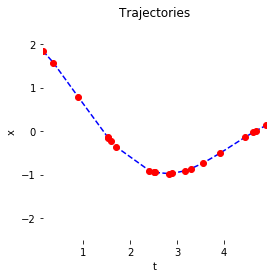

In [234]:
i_samp = 3

with torch.no_grad():
    fig = plt.figure(figsize=(4, 4), facecolor='white')
    ax_traj = fig.add_subplot(111, frameon=False)


    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x')
    ax_traj.plot(batch_t.numpy(), pred_y_final.detach().numpy()[:, i_samp, 0, 0], 'b--')
    ax_traj.plot(batch_t.numpy(), batch_y.numpy()[:, i_samp, 0, 0], 'ro')
    ax_traj.set_xlim(batch_t.numpy().min(), batch_t.numpy().max())
    ax_traj.set_ylim(-2.5, 2.5)


In [216]:
torch.sum(torch.abs(func.init_cond - batch_y0))


tensor(7.2840, grad_fn=<SumBackward0>)

# Training setting
### Unknown ODE, unknown initial condition

In [19]:
class UnknownOdeUnknownInit(nn.Module):
    
    def __init__(self, batch_size, dim=2, gamma = 1., beta = 0.5):
        super(UnknownOdeUnknownInit, self).__init__()
        self.gamma = torch.nn.Parameter(torch.tensor(gamma, dtype=torch.float32))
        self.beta = torch.nn.Parameter(torch.tensor(beta, dtype=torch.float32))
        self.dim = dim
        self.batch_size = batch_size
        # imitate the size of batch_y0
        self.init_cond = torch.nn.Parameter(torch.zeros(self.batch_size, 1, self.dim))

    def forward(self, t, y):
        y = y + self.init_cond
        y1 = y[..., 0]
        y2 = y[..., 1]
        dy1_dt = y2
        dy2_dt = - self.beta * y2 - self.gamma * y1
        
        return torch.stack((dy1_dt, dy2_dt), axis = len(dy1_dt.shape))


In [20]:
np.random.seed(0)
batch_size = 300
batch_time = 20
batch_y0, batch_t, batch_y =  get_batch(batch_size=batch_size, batch_time=batch_time)
batch_y0_init = torch.zeros_like(batch_y0)

gamma_init = np.random.uniform(size=1)
beta_init = np.random.uniform(size=1)

func2 = UnknownOdeUnknownInit(batch_size=batch_size, gamma=gamma_init, beta=beta_init)
optimizer = optim.Adam(func2.parameters(), lr=1e-3)


In [21]:
with torch.no_grad():
    func2.init_cond[:, :, 0] = batch_y0[:, :, 0]

In [22]:
print(batch_y0_init.shape)
print(batch_y.shape)
print(batch_t.shape)
print(args.batch_time)

torch.Size([300, 1, 2])
torch.Size([20, 300, 1, 2])
torch.Size([20])
20


In [31]:
print(batch_y0_init.shape)
print(batch_t.shape)
batch_t_ext = batch_t.reshape((-1, 1)).repeat(1, 5)
print(batch_t_ext.shape)
# batch_t_ext

torch.Size([300, 1, 2])
torch.Size([20])
torch.Size([20, 5])


In [23]:
ii = 0

step_size = batch_t[1]/2
batch_t_ext = batch_t.reshape((-1, 1)).repeat(1, 5)

start = time.time()
for itr in range(1, args.niters + 1):
    optimizer.zero_grad()
    
    pred_y = dto(func2, batch_y0_init, batch_t, method='euler', options={'step_size': step_size})
#     pred_y = odeint(func2, batch_y0_init, batch_t)
    pred_y_final = pred_y + func2.init_cond
    loss = torch.mean(torch.abs(pred_y_final[..., 0] - batch_y[..., 0]))
    loss.backward()
    optimizer.step()

    if itr % args.test_freq == 0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            ii += 1

    end = time.time()


Iter 0050 | Total Loss 0.027445
Iter 0100 | Total Loss 0.022281
Iter 0150 | Total Loss 0.019804
Iter 0200 | Total Loss 0.018011
Iter 0250 | Total Loss 0.016441
Iter 0300 | Total Loss 0.014981
Iter 0350 | Total Loss 0.013658
Iter 0400 | Total Loss 0.012502
Iter 0450 | Total Loss 0.011352
Iter 0500 | Total Loss 0.010229
Iter 0550 | Total Loss 0.009164
Iter 0600 | Total Loss 0.008178
Iter 0650 | Total Loss 0.007274
Iter 0700 | Total Loss 0.006470
Iter 0750 | Total Loss 0.005831
Iter 0800 | Total Loss 0.005327
Iter 0850 | Total Loss 0.004843
Iter 0900 | Total Loss 0.004366
Iter 0950 | Total Loss 0.003906
Iter 1000 | Total Loss 0.003458
Iter 1050 | Total Loss 0.003036
Iter 1100 | Total Loss 0.002650
Iter 1150 | Total Loss 0.002301
Iter 1200 | Total Loss 0.001991
Iter 1250 | Total Loss 0.001719
Iter 1300 | Total Loss 0.001468
Iter 1350 | Total Loss 0.001242
Iter 1400 | Total Loss 0.001035
Iter 1450 | Total Loss 0.000853
Iter 1500 | Total Loss 0.000719
Iter 1550 | Total Loss 0.000639
Iter 160

In [24]:
end - start

13.922156810760498

In [28]:
[1] * 3

[1, 1, 1]

In [113]:
t7o = end - start

In [105]:
print(t4o) # euler 100 step
print(t1o) # euler 5 step
print(t2o) # euler 2 step
print(t3o) # euler 1 step


587.4868896007538
295.0458381175995
285.77148842811584
283.1807482242584


In [106]:
print(t1o) # euler 5 step
print(t5o) # mid point 5 step
print(t6o) # rk4 5 step

295.0458381175995
310.64204382896423
349.37178564071655


In [114]:
print(t1o) # euler 20 time step; 5 eval per time step
print(t7o) # euler 100 time step; 5 eval per time step
print(t4o) # euler 20 time step; 100 eval per time step



295.0458381175995
1564.178207874298
587.4868896007538


In [87]:
# batch size [1, 100, 300]
[t1, t2, t3]

[258.44522500038147, 271.58105206489563, 277.9707021713257]

In [85]:
func2.gamma

Parameter containing:
tensor([0.9602], requires_grad=True)

In [86]:
func2.beta

Parameter containing:
tensor([0.0340], requires_grad=True)

In [124]:
importlib.reload(ode_models)

<module 'ode_models' from '/alt/applic/user-maint/zq224/WS/torchdiffeq/examples/ode_models.py'>

In [159]:
D_TYPE = torch.float32

np.random.seed(0)
batch_size = 300
batch_time = 100
batch_y0, batch_t, batch_y =  get_batch(batch_size=batch_size, batch_time=batch_time)

dat_dict = dict()
for i in range(batch_size):
    dat_dict[str(i)] = dict(t=batch_t, x=batch_y[:, i:i+1, :, 0:1])
    

batch_y0_init = torch.zeros_like(batch_y0)



func3 = ode_models.HigherOrderOde(dat_dict,batch_size=batch_size, dim=1, order=2, hidden_size=50)

optimizer = optim.Adam(func3.parameters(), lr=1e-3)


In [132]:
n_processed = 0
s = time.time()
for eid, v in dat_dict.items():
    t = v['t']
    x = v['x']

    optimizer.zero_grad()
    
    
    func3.set_init_cond([eid])
    init_zeros = torch.zeros_like(func3.init_cond)
    
    pred_y = odeint(func3, init_zeros, t)
    pred_y_final = pred_y  + func3.init_cond
    loss = torch.mean(torch.abs(pred_y_final[..., :func3.dim] - x))
    loss.backward()
    optimizer.step()
    
    n_processed += 1
    
    if n_processed % 10 == 0:
        print('Processed:', n_processed)
    if n_processed > 100:
        break
e = time.time()

Processed: 10
Processed: 20
Processed: 30
Processed: 40
Processed: 50
Processed: 60
Processed: 70
Processed: 80
Processed: 90
Processed: 100


In [162]:
n_processed = 0


start = time.time()
for itr in range(1, 100 + 1):
    optimizer.zero_grad()
    
    func3.set_init_cond(list(dat_dict.keys()))
    init_zeros = torch.zeros_like(func3.init_cond)
    
    pred_y = odeint(func3, init_zeros, batch_t)
    pred_y_final = pred_y + func3.init_cond
    loss = torch.mean(torch.abs(pred_y_final[..., 0] - batch_y[..., 0]))
    loss.backward()
    optimizer.step()

    n_processed += 1
    if n_processed % 10 == 0:
        print('Processed:', n_processed)
    if n_processed > 100:
        break
    end = time.time()


Processed: 10
Processed: 20
Processed: 30
Processed: 40
Processed: 50
Processed: 60
Processed: 70
Processed: 80
Processed: 90
Processed: 100


In [163]:
loss

tensor(0.0009, grad_fn=<MeanBackward0>)

In [164]:
torch.mean(torch.abs(pred_y_final - batch_y))

tensor(0.0039, grad_fn=<MeanBackward0>)

In [143]:
end - start

87.54762482643127

In [167]:
pred_y_final.min()

tensor(-1.5680, grad_fn=<MinBackward1>)

In [168]:
pred_y_final.max().to(pred_y_final)

tensor(2.2210, grad_fn=<MaxBackward1>)

In [138]:
batch_y.shape

torch.Size([100, 300, 1, 2])

In [140]:
func3.dim

1

In [129]:
dat_dict['0']['x'].shape

torch.Size([100, 1, 1, 2])

In [116]:
batch_y.shape

torch.Size([100, 300, 1, 2])

In [24]:
plot_func = func
with torch.no_grad():
    pred_y = odeint(plot_func, true_y0[:, 0], t)


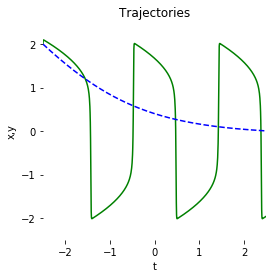

In [28]:
import matplotlib.pyplot as plt

with torch.no_grad():
    fig = plt.figure(figsize=(4, 4), facecolor='white')
    ax_traj = fig.add_subplot(111, frameon=False)


    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.numpy(), true_y.numpy()[:, :, 0], 'g-')
    ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0], 'b--')
    ax_traj.set_xlim(t.min(), t.max())
    ax_traj.set_ylim(-2.5, 2.5)


In [84]:
# augmented

ii = 0

func = ode_models.ODEFunc(dim_y=2)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)


In [99]:

# args.niters + 1
for itr in range(1, 20+ 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
#     batch_y0[..., 1] = 0
    
#     print(batch_y0.shape)
#     print(batch_y.shape)
    
    pred_y = odeint(func, batch_y0, batch_t)
#     print(pred_y[..., 0].shape)
#     print(batch_y[..., 0].shape)
    loss = torch.mean(torch.abs(pred_y[..., 0] - batch_y[..., 0]))
    
#     loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            true_y0_aug = true_y0
#             true_y0_aug[..., 1] = 0
            pred_y = odeint(func, true_y0_aug, t)
#             print(pred_y.shape)
#             print(true_y.shape)
            loss = torch.mean(torch.abs(pred_y[..., 0] - true_y[..., 0]))
#             loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()


Iter 0020 | Total Loss 1.559551


In [100]:
plot_func = func
with torch.no_grad():
    pred_y = odeint(plot_func, true_y0_aug, t)


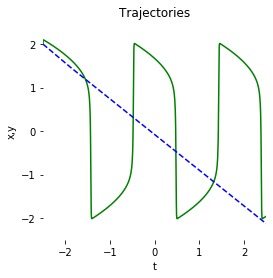

In [101]:
with torch.no_grad():
    fig = plt.figure(figsize=(4, 4), facecolor='white')
    ax_traj = fig.add_subplot(111, frameon=False)

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.numpy(), true_y.numpy()[:, :, 0], 'g-')
    ax_traj.plot(t.numpy(), pred_y.numpy()[:, :, 0], 'b--')
    ax_traj.set_xlim(t.min(), t.max())
    ax_traj.set_ylim(-2.5, 2.5)

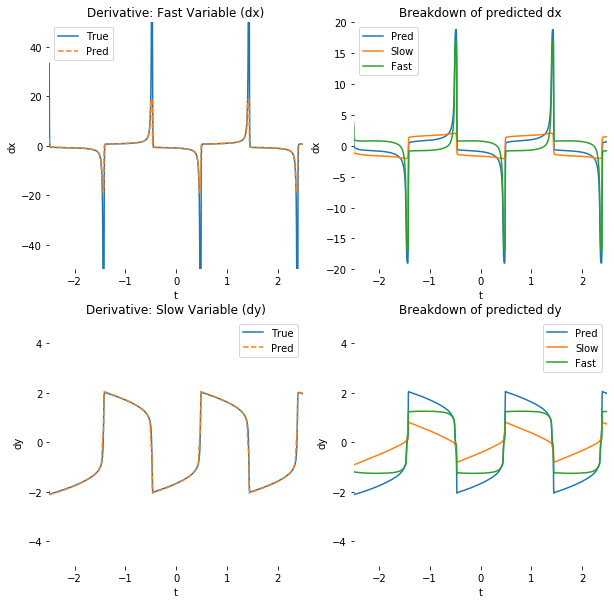

In [31]:
with torch.no_grad():
    grad_true = Lambda()(t, true_y.squeeze())
    
    grad_pred = func(t, true_y).squeeze()
    
    grad_slow = func_slow(t, true_y).squeeze()
    grad_fast = func_fast(t, true_y).squeeze()
    
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    
    fig1 = fig.add_subplot(221, frameon=False)
    fig1.cla()
    fig1.set_title('Derivative: Fast Variable (dx)')
    fig1.set_xlabel('t')
    fig1.set_ylabel('dx')
    fig1.plot(t.numpy(), grad_true.numpy()[:, 0], label='True')
    fig1.plot(t.numpy(), grad_pred.numpy()[:, 0], '--', label='Pred')
    fig1.set_xlim(t.min(), t.max())
    fig1.set_ylim(-50., 50.)
    fig1.legend()
    
    fig2 = fig.add_subplot(222, frameon=False)
    fig2.cla()
    fig2.set_title('Breakdown of predicted dx')
    fig2.set_xlabel('t')
    fig2.set_ylabel('dx')
    fig2.plot(t.numpy(), grad_pred.numpy()[:, 0], label='Pred')
    fig2.plot(t.numpy(), grad_slow.numpy()[:, 0], label='Slow')
    fig2.plot(t.numpy(), grad_fast.numpy()[:, 0], label='Fast')
    fig2.set_xlim(t.min(), t.max())
    fig2.set_ylim(-20., 20.)
    fig2.legend()
    
    fig3 = fig.add_subplot(223, frameon=False)
    fig3.cla()
    fig3.set_title('Derivative: Slow Variable (dy)')
    fig3.set_xlabel('t')
    fig3.set_ylabel('dy')
    fig3.plot(t.numpy(), grad_true.numpy()[:, 1], label='True')
    fig3.plot(t.numpy(), grad_pred.numpy()[:, 1], '--', label='Pred')
    fig3.set_xlim(t.min(), t.max())
    fig3.set_ylim(-5., 5.)
    fig3.legend()
    
    fig4 = fig.add_subplot(224, frameon=False)
    fig4.cla()
    fig4.set_title('Breakdown of predicted dy')
    fig4.set_xlabel('t')
    fig4.set_ylabel('dy')
    fig4.plot(t.numpy(), grad_pred.numpy()[:, 1], label='Pred')
    fig4.plot(t.numpy(), grad_slow.numpy()[:, 1], label='Slow')
    fig4.plot(t.numpy(), grad_fast.numpy()[:, 1], label='Fast')
    fig4.set_xlim(t.min(), t.max())
    fig4.set_ylim(-5., 5.)
    fig4.legend()

In [73]:
grad_pred.squeeze().shape

torch.Size([1000, 2])